In [29]:
import math


class Value:

  def __init__(self, data, _children=(), _op="", label="") -> None:
    self.data = data
    self._prev = set(_children) # why set? -> he says for efficiency
    self._backward = lambda: None
    self._op = _op
    self.grad = 0 # first assume it has no effect in the output
    self.label = label

  def __repr__(self) -> str:
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), "+")
    def _backward():
      self.grad += 1.0 * out.grad # chain rule
      other.grad += 1.0 * out.grad # chain rule

    out._backward = _backward
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), "*")
    def _backward():
      self.grad += other.data * out.grad # chain rule
      other.grad += self.data * out.grad # chain rule

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad # chain rule

    out._backward = _backward
    return out
  
  def backward(self):
  
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [30]:
a = Value(2.0, label="a")
b = Value(-3.0, label = "b")
c = Value(10.0, label="c")
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"

In [31]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

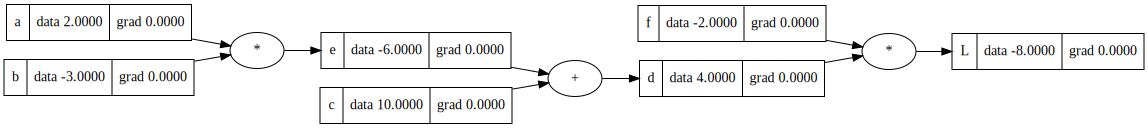

In [32]:
draw_dot(L)

Escribiendo una neurona:

In [33]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()

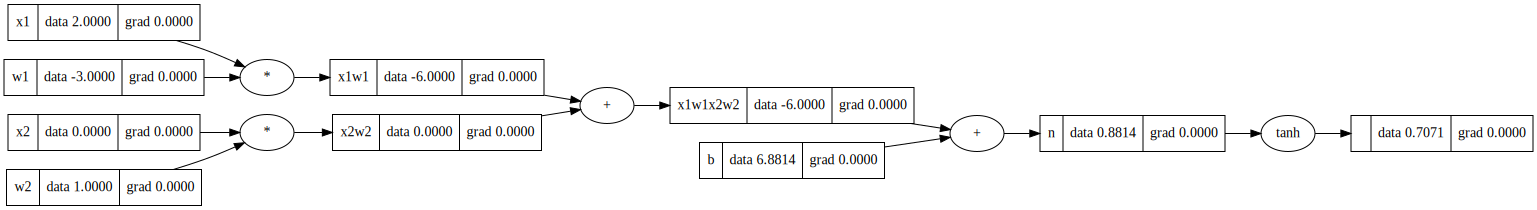

In [34]:
draw_dot(o)

Backpropagate

In [35]:
o.backward()

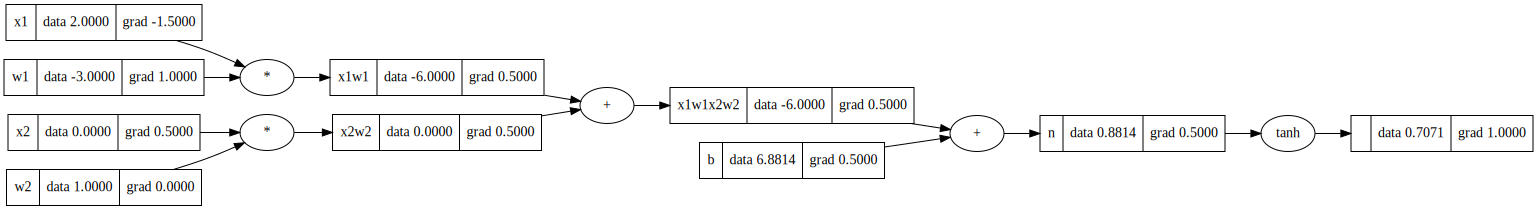

In [36]:
draw_dot(o)